# Analysis experiment 1: default values

The goal of the first experiment is to find sensible default values, based on performance data of random hyperparameter settings across different datasets.

In [1]:
import hyperimp.evaluate.default_params as hyperimp
import pandas as pd
from scipy.io import arff
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [17]:
# load data
svm = pd.DataFrame(arff.loadarff('01 data/exp1/meta_svm.arff')[0])
svm['kernel'] = svm['kernel'].str.decode('utf-8')
svm['shrinking'] = svm['shrinking'].str.decode('utf-8').map({'True' : True, 'False' : False})
#svm['shrinking'] = svm['kernel'].str.decode('utf-8')
rf = pd.DataFrame(arff.loadarff('01 data/exp1/meta_rf.arff')[0])
rf['bootstrap'] = rf['bootstrap'].str.decode("utf-8").map({'True' : True, 'False' : False})
rf['criterion'] = rf['criterion'].str.decode("utf-8")

In [18]:
# algorithms to be evaluated
alg_names = ['rf', 'svm']
# hyperparameters to be evaluated
alg_params = {'svm': ['gamma','C','tol', 'shrinking'],
              'rf': ['bootstrap', 'criterion', 'max_features','min_samples_leaf','min_samples_split']}
# parameters defined on a log and integer scale
logs = ['gamma', 'C', 'tol']
integer = ['min_samples_leaf', 'min_samples_split']
boolnom = ['bootstrap', 'criterion', 'shrinking']

## Distribution of top _n_ per hyperparameter

The intuition behind our method of finding default values, is to find the hyperparameter value that most often resulted in good performance. To this end, we first take a subset of the top _n_ performance data points of each dataset. Note that this subset contains _n_ * nr. of datasets datapoints. To get an idea of the distribution of the hyperparameters within the top _n_ dat points, we visualize them in a histogram.

In [21]:
n = 1000
m = 600

# initialze alg objects
algs = hyperimp.init_algs('hyperimp/evaluate/parameters.csv', {'svm': svm, 'rf': rf})

# get top n data
dfs = [hyperimp.get_topn(alg, n, m, False) for alg in algs]

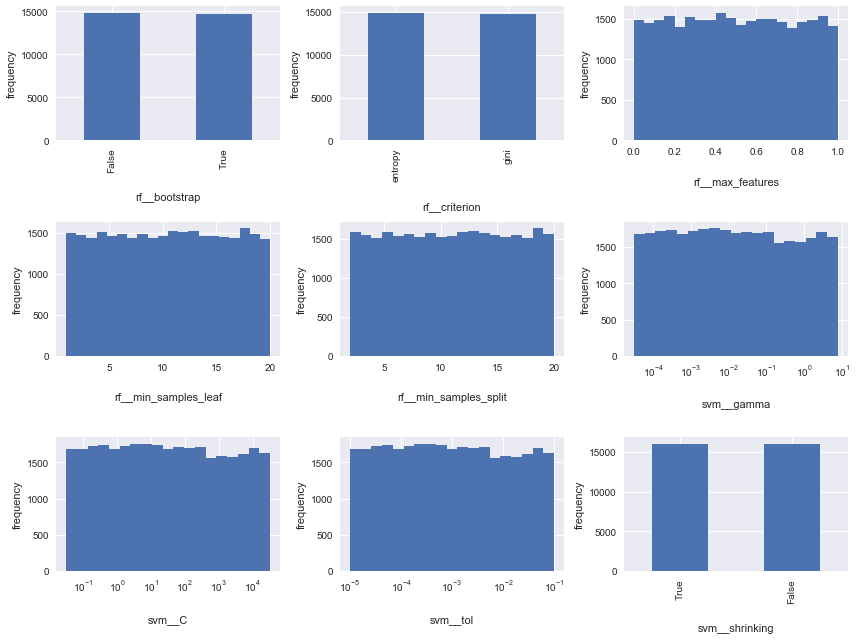

In [22]:
grid = True # put images on grid or not
cols = 3 # set nr columns in figure grid
ymax = None # set upper limit of plot; None for auto

if grid:
    nr_plots = sum([len(value) for key, value in alg_params.items()])
    rows = math.ceil(sum([len(value) for key, value in alg_params.items()])/cols)
    plt.figure(figsize = (4*cols,3*rows))
    index = 0
for alg, df in zip(alg_names, dfs):
    for param in alg_params[alg]:
        if grid:
            index += 1
            plt.subplot(rows, cols, index)
        if param in boolnom:
            df[param].value_counts().plot(kind='bar', color = sns.color_palette()[0])
        else:
            bins = 20
            log = param in logs
            intg = param in integer
            if log:
                bins = np.logspace(np.log10(min(df[param])), np.log10(max(df[param])), 20)
                plt.xscale('log', basex=10)
            if intg:
                bins = int(max(df[param]) - min(df[param]) + 1)
            plt.hist(df[param], bins = bins)
        plt.xlabel('%s__%s' % (alg, param), labelpad=20)
        plt.ylim(0,ymax)
        plt.ylabel('frequency')
        plt.tight_layout()
        if not grid:
            #plt.savefig('figures/histograms/hist__%s__%s.eps' % (alg, param), format = 'eps')
            plt.show()
if grid:
    plt.show()

## Default parameters

In [6]:
n = 10
m = 800

# requires parameters.csv (hyperimp/evaluate) and data in algs to be configured correctly!
for alg in algs:
    df = hyperimp.get_topn(alg, n, m, False)
    def_params = hyperimp.find_default(alg, df, False)
    def_params_df = pd.DataFrame(def_params).transpose()
    print('Average default value %s:' %alg.name)
    display(def_params_df.mean())
    print('Standard deviation default value %s:' %alg.name)
    display(def_params_df.std())
    display(pd.DataFrame(hyperimp.find_default(alg, df, True)).transpose())
    #display(def_params_df)

Average default value rf:


bootstrap            0.000000
max_features         0.059254
min_samples_leaf     1.000000
min_samples_split    3.000000
dtype: float64

Standard deviation default value rf:


bootstrap            0.000000
max_features         0.003544
min_samples_leaf     0.000000
min_samples_split    0.000000
dtype: float64

,bootstrap,criterion,max_features,min_samples_leaf,min_samples_split
3.0,"(False, False, False)","(gini, gini, gini)","(0.002259233518513537, 0.1114436851885751, 0.0...","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"
6.0,"(False, False, False)","(gini, gini, gini)","(0.002259233518513537, 0.12509174164733278, 0....","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"
11.0,"(False, False, False)","(gini, gini, gini)","(0.002259233518513537, 0.12509174164733278, 0....","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"
12.0,"(False, False, False)","(gini, gini, gini)","(0.009379422328582243, 0.13132190685614292, 0....","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"
14.0,"(False, False, False)","(gini, gini, gini)","(0.002259233518513537, 0.12509174164733278, 0....","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"
15.0,"(False, False, False)","(gini, gini, gini)","(0.002259233518513537, 0.12509174164733278, 0....","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"
16.0,"(False, False, False)","(gini, gini, gini)","(0.002259233518513537, 0.12509174164733278, 0....","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"
18.0,"(False, False, False)","(gini, gini, gini)","(0.002259233518513537, 0.1114436851885751, 0.0...","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"
22.0,"(False, False, False)","(gini, gini, gini)","(0.002259233518513537, 0.12509174164733278, 0....","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"
23.0,"(False, False, False)","(gini, gini, gini)","(0.002259233518513537, 0.1114436851885751, 0.0...","(1.0, 1.0, 1.0)","(3.0, 3.0, 3.0)"


Average default value svm:


C            15.764581
gamma         0.008248
shrinking     0.015152
tol           0.000622
dtype: float64

Standard deviation default value svm:


C            2.913718
gamma        0.001399
shrinking    0.000000
tol          0.000082
dtype: float64

,C,gamma,shrinking,tol
3.0,"(6.1341471807627395, 12.242248424451748, 8.665...","(0.0035331641767400892, 0.006580518506568341, ...","(True, True, True)","(0.00033371256302304106, 0.0005281524865961869..."
6.0,"(9.522070034827603, 17.846617399810377, 13.035...","(0.005248597627357243, 0.009238157611466858, 0...","(True, True, True)","(0.0004469459929336599, 0.000678446724560331, ..."
11.0,"(9.522070034827603, 17.846617399810377, 13.035...","(0.005248597627357243, 0.009238157611466858, 0...","(True, True, True)","(0.0004469459929336599, 0.000678446724560331, ..."
12.0,"(12.242248424451748, 24.43251556728308, 17.294...","(0.006580518506568341, 0.012256216141997291, 0...","(True, True, True)","(0.0005281524865961869, 0.000835884171008798, ..."
14.0,"(12.242248424451748, 24.43251556728308, 17.294...","(0.006580518506568341, 0.012256216141997291, 0...","(True, True, True)","(0.0005281524865961869, 0.000835884171008798, ..."
15.0,"(12.242248424451748, 24.43251556728308, 17.294...","(0.006580518506568341, 0.012256216141997291, 0...","(True, True, True)","(0.0005281524865961869, 0.000835884171008798, ..."
16.0,"(6.1341471807627395, 12.242248424451748, 8.665...","(0.0035331641767400892, 0.006580518506568341, ...","(True, True, True)","(0.00033371256302304106, 0.0005281524865961869..."
18.0,"(9.522070034827603, 17.846617399810377, 13.035...","(0.005248597627357243, 0.009238157611466858, 0...","(True, True, True)","(0.0004469459929336599, 0.000678446724560331, ..."
22.0,"(12.242248424451748, 24.43251556728308, 17.294...","(0.006580518506568341, 0.012256216141997291, 0...","(True, True, True)","(0.0005281524865961869, 0.000835884171008798, ..."
23.0,"(6.1341471807627395, 12.242248424451748, 8.665...","(0.0035331641767400892, 0.006580518506568341, ...","(True, True, True)","(0.00033371256302304106, 0.0005281524865961869..."


In [9]:
for alg in algs:
    topn = hyperimp.get_topn(alg, n, m, False)
    def_params = hyperimp.find_default(alg, topn, True)
    for key, value in hyperimp.default_score(alg, topn, def_params).items():
        print('%s \t %s : %f' %(alg.name, key, value))

rf 	 max_features : 0.244828
rf 	 min_samples_leaf : 0.393103
rf 	 min_samples_split : 0.117241
rf 	 criterion : 0.527586
rf 	 bootstrap : 0.620690
svm 	 gamma : 0.044828
svm 	 C : 0.044828
svm 	 tol : 0.044828
svm 	 shrinking : 0.524138
